In [1]:
import medmnist
from medmnist import BloodMNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

2025-05-09 17:14:16.664311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, optimizers, callbacks, Model, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve
import time

In [3]:
class BloodMNISTDataLoader:
    def __init__(self):
        self.train_dataset = BloodMNIST(split="train", download=True, transform=None)
        self.val_dataset = BloodMNIST(split="val", download=True, transform=None)
        self.test_dataset = BloodMNIST(split="test", download=True, transform=None)

        self.X_train, self.y_train = self._prepare_data(self.train_dataset)
        self.X_val, self.y_val = self._prepare_data(self.val_dataset)
        self.X_test, self.y_test = self._prepare_data(self.test_dataset)

        print(f"X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")
        print(f"X_val shape: {self.X_val.shape}, y_val shape: {self.y_val.shape}")
        print(f"X_test shape: {self.X_test.shape}, y_test shape: {self.y_test.shape}")

    def _prepare_data(self, dataset):
        X = dataset.imgs.astype("float32") / 255.0
        X = X.reshape(-1, 28, 28, 3)
        y = dataset.labels.squeeze()
        y = to_categorical(y, num_classes=8)
        return X, y

    def show_sample_images(self, n = 10, dataset = "test"):
        if dataset == "train":
            X, y = self.X_train, self.y_train
        elif dataset == "val":
            X, y = self.X_val, self.y_val
        else:
            X, y = self.X_test, self.y_test

        plt.figure(figsize=(n, 2))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(X[i])
            label = np.argmax(y[i])
            plt.title(f"Label: {label}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    def plot_label_histograms(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for idx, (name, y) in enumerate([
            ("Training set", self.y_train),
            ("Validation set", self.y_val),
            ("Test set", self.y_test)
        ]):
            labels = np.argmax(y, axis=1)
            unique, counts = np.unique(labels, return_counts=True)
            axes[idx].bar(unique, counts, color=['blue', 'green', 'red'][idx])
            axes[idx].set_title(name)
            axes[idx].set_xlabel("Class")
            axes[idx].set_ylabel("Count")

        plt.tight_layout()
        plt.show()

X_train shape: (11959, 28, 28, 3), y_train shape: (11959, 8)
X_val shape: (1712, 28, 28, 3), y_val shape: (1712, 8)
X_test shape: (3421, 28, 28, 3), y_test shape: (3421, 8)


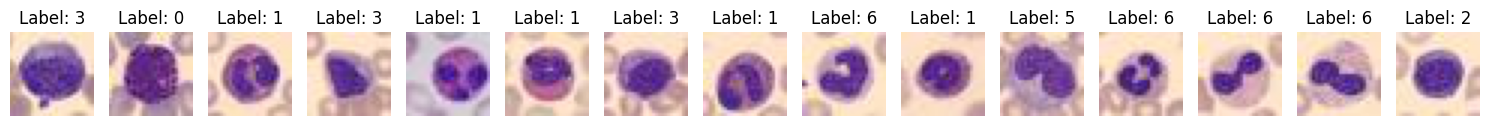

In [ ]:
loader = BloodMNISTDataLoader()

loader.show_sample_images(n=15, dataset="test")
loader.plot_label_histograms()

X_train, y_train = loader.X_train, loader.y_train
X_val, y_val = loader.X_val, loader.y_val
X_test, y_test = loader.X_test, loader.y_test

#print(y_train[0])

In [15]:
from tensorflow.keras import layers, Model, Input

def resnet_block(x, filters, downsample=False):
    shortcut = x
    stride = 2 if downsample else 1

    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x
    
def ResNet18(input_shape=(28, 28, 3), num_classes=8):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = resnet_block(x, 32)
    x = resnet_block(x, 32)

    x = resnet_block(x, 64, downsample=True)
    x = resnet_block(x, 64)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='ResNet18')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [67]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models, optimizers, callbacks

#model = ResNet_model() 
model = ResNet18()
#model.summary()

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=1e-6,
    verbose = True
)
#lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.1 if epoch in [50, 75] else lr)

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    restore_best_weights=True
)


history = model.fit(X_train, y_train, epochs=35, batch_size=128, validation_data=(X_val, y_val), callbacks = [reduce_lr]) # batch_size -> bigger the better; smaller the faster

# Metrix
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.2847 - loss: 2.0627 - val_accuracy: 0.1373 - val_loss: 4.0685 - learning_rate: 1.0000e-04
Epoch 2/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7788 - loss: 0.7067 - val_accuracy: 0.1373 - val_loss: 6.2380 - learning_rate: 1.0000e-04
Epoch 3/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8420 - loss: 0.5190 - val_accuracy: 0.1928 - val_loss: 5.7982 - learning_rate: 1.0000e-04
Epoch 4/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8633 - loss: 0.4368 - val_accuracy: 0.2120 - val_loss: 5.1172 - learning_rate: 1.0000e-04
Epoch 5/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8818 - loss: 0.3876 - val_accuracy: 0.3072 - val_loss: 2.4608 - learning_rate: 1.0000e-04
Epoch 6/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8964 - loss: 0.3455 - val_accuracy: 0.6688 - val_loss: 0.9220 - learning_rate: 1.0000e-04
Epoch 7/35
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9094

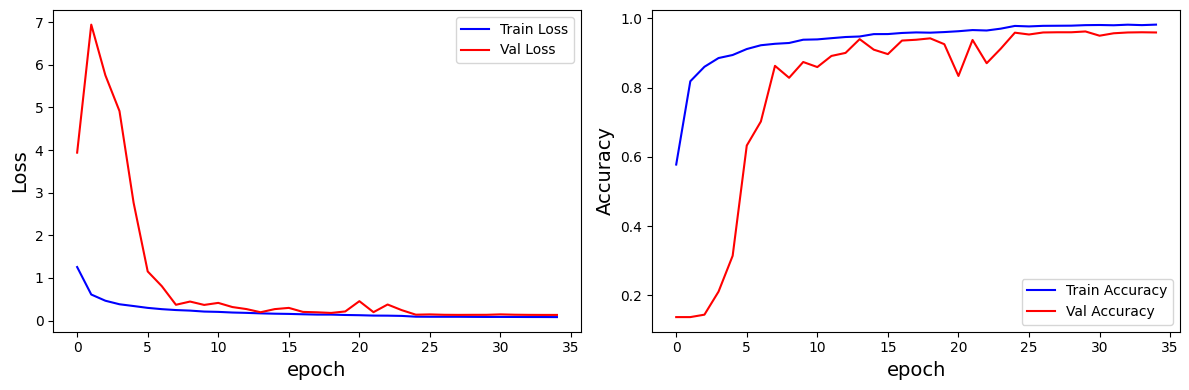

In [17]:
x = 0
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][x:], label='Train Loss', c = 'b')
plt.plot(history.history['val_loss'][x:], label='Val Loss',  c = 'r')
plt.legend()
plt.xlabel('epoch', fontsize = "14")
plt.ylabel('Loss', fontsize = "14")
plt.tight_layout()
plt.savefig("CNN_loss.png")
#plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'][x:], label='Train Accuracy', c = 'b')
plt.plot(history.history['val_accuracy'][x:], label='Val Accuracy', c = 'r')
plt.legend()
plt.xlabel('epoch', fontsize = "14")
plt.ylabel('Accuracy', fontsize = "14")
#plt.title("Accuracy")
plt.tight_layout()
#plt.savefig("ResNet18_accuracy[20:].png")
plt.show()

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


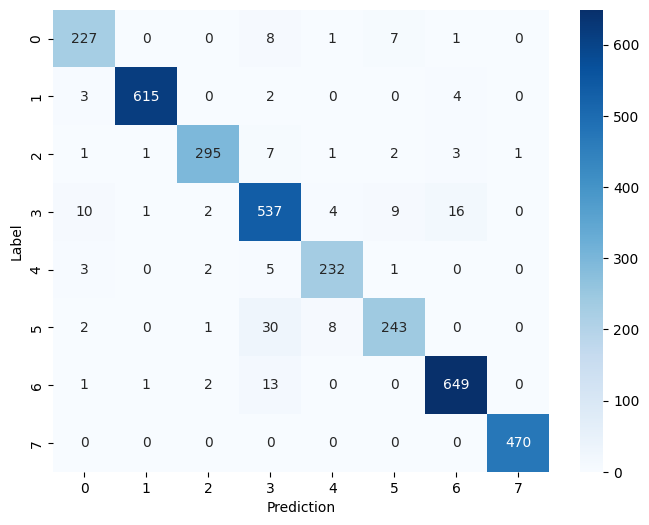

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.argmax(y_test, axis=1)  
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.xlabel('Prediction')
plt.ylabel('Label')
#plt.savefig("ResNet18_cm.png")
plt.show()

In [73]:
class AccuracyByDataSize:
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, model_class, min_epochs=35, max_epochs=100, repetitions=5):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.model_class = model_class
        self.min_epochs = min_epochs
        self.max_epochs = max_epochs
        self.repetitions = repetitions

    def get_random_subset(self, dataset, size):
        X, y = dataset
        indices = np.random.choice(X.shape[0], size=int(size * X.shape[0]), replace=False)
        X_subset = X[indices]
        y_subset = y[indices]
        return X_subset, y_subset

    def train_model_on_random_subset(self, size):
        if size == 1.0:
            X_train_subset, y_train_subset = self.X_train, self.y_train
            X_val_subset, y_val_subset = self.X_val, self.y_val
            X_test_subset, y_test_subset = self.X_test, self.y_test
        else:
            X_train_subset, y_train_subset = self.get_random_subset((self.X_train, self.y_train), size)
            X_val_subset, y_val_subset = self.get_random_subset((self.X_val, self.y_val), size)
            X_test_subset, y_test_subset = self.get_random_subset((self.X_test, self.y_test), size)

        #X_train_subset, y_train_subset = self.get_random_subset((self.X_train, self.y_train), size)
        #X_val_subset, y_val_subset = self.get_random_subset((self.X_val, self.y_val), size)
        #X_test_subset, y_test_subset = self.get_random_subset((self.X_test, self.y_test), size)

        model = self.model_class()
        '''callbacks = [
            ReduceLROnPlateau(monitor='val_loss', 
                                    factor=0.5, 
                                    patience=5, 
                                    min_lr=1e-6,
                                    verbose = True
                            )
        ]'''
        reduce_lr = ReduceLROnPlateau(
                                        monitor='val_loss', 
                                        factor=0.1, 
                                        patience=5, 
                                        min_lr=1e-6,
                                        verbose = True
                                        )

        history = model.fit(X_train_subset, y_train_subset, 
                            epochs=self.calculate_epochs(size),
                            batch_size=128, 
                            validation_data=(X_val_subset, y_val_subset),
                            callbacks= [reduce_lr],
                            verbose=False)

        test_loss, test_acc = model.evaluate(X_test_subset, y_test_subset)
        print(f"Test accuracy: {test_acc:.4f}")
        return test_acc

    def calculate_epochs(self, size):
        return int(self.min_epochs + (self.max_epochs - self.min_epochs) * (1 - size))

    def calculate_accuracy_by_size(self, sizes):
        means = []
        stds = []
        for size in sizes:
            print(f"=== Training on {int(size * 100)}% of data ===")
            accuracies_for_size = []
            for _ in range(self.repetitions):
                accuracy = self.train_model_on_random_subset(size)
                accuracies_for_size.append(accuracy)
            mean_accuracy = np.mean(accuracies_for_size)
            std_accuracy = np.std(accuracies_for_size)
            means.append(mean_accuracy)
            stds.append(std_accuracy)
        return means, stds


    def plot_accuracy_vs_data_size(self, sizes):
        means, stds = self.calculate_accuracy_by_size(sizes)
        percentages = [int(size * 100) for size in sizes]

        
        plt.figure(figsize=(6, 4))
        plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, elinewidth=2)

        for x, y in zip(percentages, means):
            plt.text(x + 5, y + 0.01, f"{y:.3f}", ha='center', fontsize=10, color='black')
            
        #plt.title("Accuracy vs Data Size", fontsize=18)
        plt.xlabel("Percentage of data used [%]", fontsize=18)
        plt.ylabel("Accuracy - test", fontsize=18)
        plt.ylim((0,1.0))
        plt.xlim((0,105))
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('accuracy_vs_data_size.png')
        print('Plot has been saved as accuracy_vs_data_size.png')
        plt.show()

        print("means: ", means)
        print("stds: ", stds)

        return means, stds
        
        

=== Training on 100% of data ===

Epoch 23: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9442 - loss: 0.1619
Test accuracy: 0.9483

Epoch 28: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9448 - loss: 0.1536
Test accuracy: 0.9480

Epoch 26: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9485 - loss: 0.1530
Test accuracy: 0.9556
Plot has been saved as accuracy_vs_data_size.png


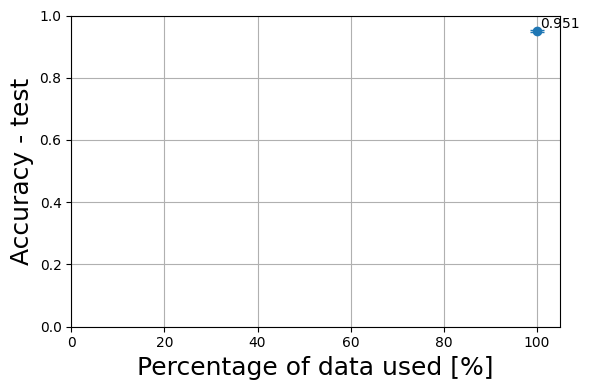

means:  [np.float64(0.9505992333094279)]
stds:  [np.float64(0.0035158646456038916)]
[np.float64(0.9505992333094279)]


In [74]:
accuracy_model = AccuracyByDataSize(X_train, y_train, X_val, y_val, X_test, y_test, ResNet18, min_epochs=35, max_epochs=80, repetitions=3)

#sizes = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
sizes = [1.0]
means, stds = accuracy_model.plot_accuracy_vs_data_size(sizes)
print(means)

Plot has been saved as accuracy_vs_data_size.png


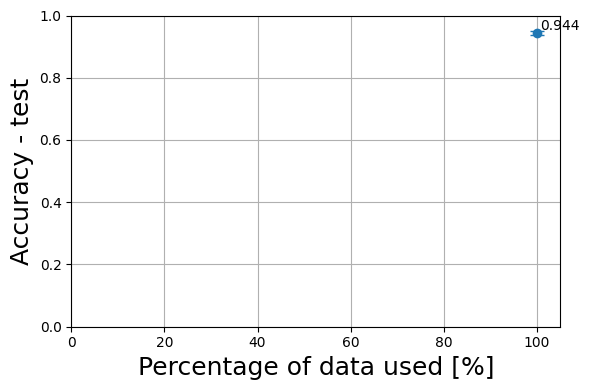

means:  [np.float64(0.9444606701532999)]
stds:  [np.float64(0.007313640746032675)]


In [71]:
percentages = [int(size * 100) for size in sizes]

plt.figure(figsize=(6, 4))
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, elinewidth=2)

for x, y in zip(percentages, means):
    plt.text(x + 5, y + 0.01, f"{y:.3f}", ha='center', fontsize=10, color='black')
    
#plt.title("Accuracy vs Data Size", fontsize=18)
plt.xlabel("Percentage of data used [%]", fontsize=18)
plt.ylabel("Accuracy - test", fontsize=18)
plt.ylim((0,1.0)) 
plt.xlim((0,105))
plt.grid(True)
plt.tight_layout()
#plt.savefig('accuracy_vs_data_size.png')
print('Plot has been saved as accuracy_vs_data_size.png')
plt.show()

print("means: ", means)
print("stds: ", stds)

In [156]:
def split_subset_and_rest(X, y, subset_size: int):
    total_size = len(X)

    indices = np.arange(total_size)
    np.random.shuffle(indices)

    subset_indices = indices[:subset_size]
    rest_indices = indices[subset_size:]

    X_subset = X[subset_indices]
    y_subset = y[subset_indices]

    X_rest = X[rest_indices]
    y_rest = y[rest_indices]

    return X_subset, y_subset, X_rest, y_rest

In [151]:
subset_size = len(X_train) * 0.1
epochs = 100
X_train_subset, y_train_subset, X_train_rest, y_train_rest = split_subset_and_rest(X_train, y_train, int(subset_size))
X_val_subset, y_val_subset, X_val_rest, y_val_rest = split_subset_and_rest(X_val, y_val, int(subset_size))
X_test_subset, y_test_subset, X_test_rest, y_test_rest = split_subset_and_rest(X_test, y_test, int(subset_size))

print('X_train_subset shape:', X_train_subset.shape)
print('y_train_subset shape:', y_train_subset.shape)
print('X_val_subset shape:', X_val_subset.shape)
print('y_val_subset shape:', y_val_subset.shape)
print('X_test_subset shape:', X_test_subset.shape)
print('y_test_subset shape:', y_test_subset.shape)

model_10_v1 = ResNet18()

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6,
    verbose = True
)

#lr_schedule = callbacks.LearningRateScheduler(lambda epoch, lr: lr * 0.1 if epoch in [50, 75] else lr)

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=40, 
    restore_best_weights=True
)

history = model_10_v1.fit(X_train_subset, y_train_subset, 
                    epochs=epochs, 
                    batch_size=128, 
                    validation_data=(X_val_subset, y_val_subset), 
                    callbacks = [early_stopping,reduce_lr],
                    verbose = True
                   ) 

test_loss, test_acc = model_10_v1.evaluate(X_test_subset, y_test_subset)

[3038 7169 6883 ... 7657 3077 3768]
[10371  7257  4394 ...  9259  1356  7202]


IndexError: index 10371 is out of bounds for axis 0 with size 1712

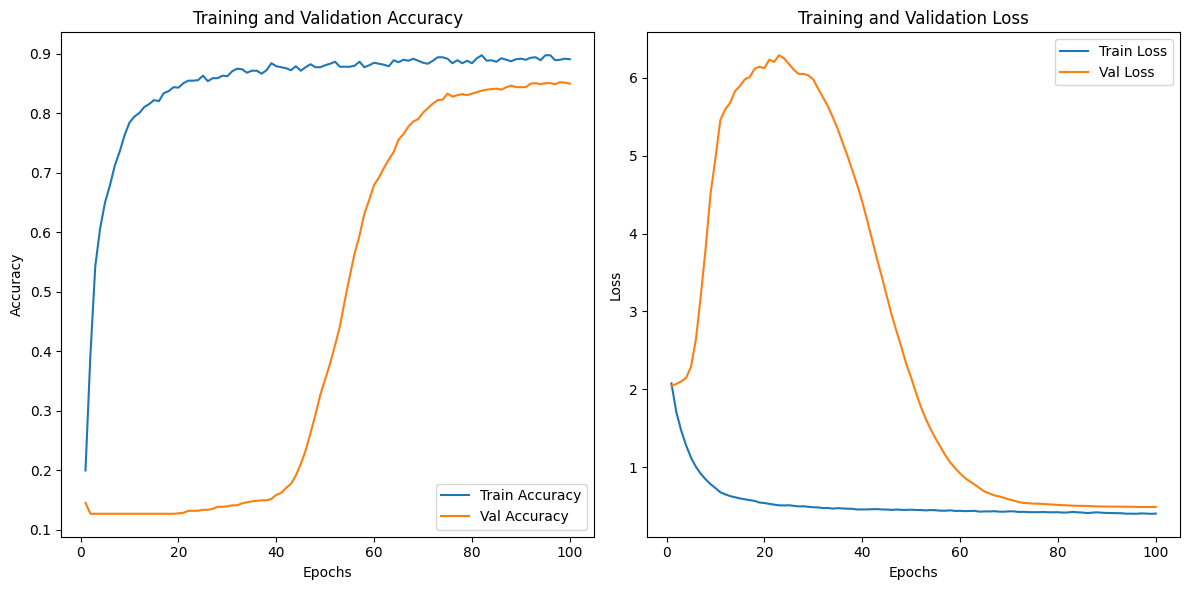

In [141]:
import matplotlib.pyplot as plt

# Historia treningu
history_dict = history.history
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_accuracy) + 1)

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Próbka 0: [5.3868670e-04 6.7462242e-04 8.8564806e-02 2.3406125e-03 7.1888105e-03
 2.1911506e-04 1.4201089e-02 8.8627231e-01]
Próbka 1: [5.6931913e-05 1.1564462e-04 2.5019107e-02 8.1452180e-04 7.0268719e-04
 1.9918898e-05 1.2799705e-03 9.7199112e-01]
Próbka 2: [0.05948864 0.018787   0.05311282 0.20339537 0.04366559 0.20971474
 0.38690254 0.02493333]
Próbka 3: [3.0948893e-05 9.9978030e-01 1.8547911e-05 9.2137532e-05 1.0759284e-05
 5.9195963e-06 3.8254664e-05 2.3047745e-05]
Próbka 4: [0.01049466 0.00356861 0.52544343 0.3211432  0.05981244 0.06387527
 0.01011454 0.00554778]
Próbka 5: [2.7046828e-03 1.0886673e-03 4.3936705e-04 1.2896283e-04 5.7292031e-03
 1.6663100e-03 9.8794782e-01 2.9482154e-04]
Próbka 6: [1.5141376e-03 9.9244153e-01 3.2935382e-04 2.6176115e-03 2.6853071e-04
 2.5445005e-04 1.5032231e-03 1.0711062e-03]
Próbka 7: [5.3139282e-03 2.8731194e-03 8.2067735e-03 1.0420064e-03 2.8914247e-02
 5.7288660e-03 9.4716024e-01 7.6081819e-04]
Próbka 8

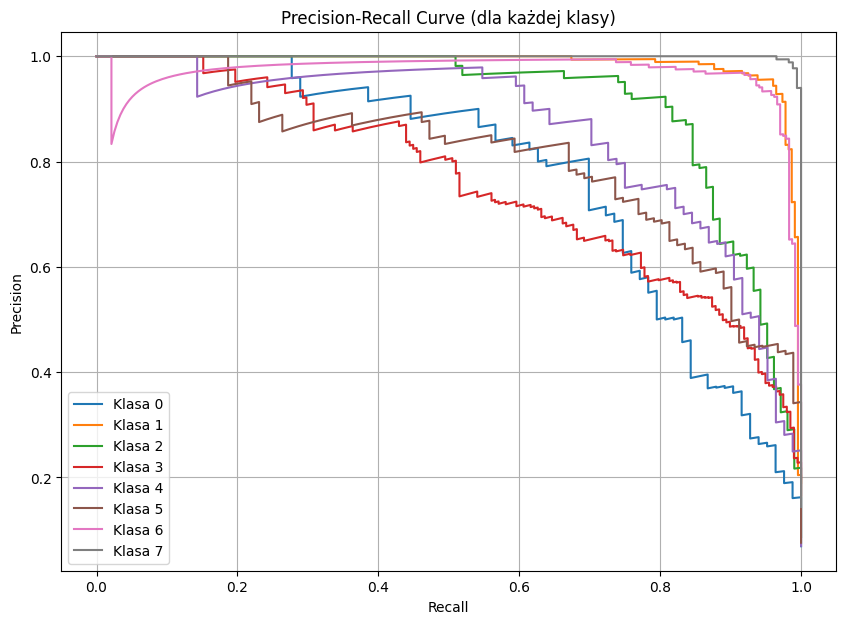

In [143]:
y_true = np.argmax(y_test_subset, axis=1)
y_probs = model_10_v1.predict(X_test_subset) 
for i in range(20):
    print(f"Próbka {i}: {y_probs[i]}")

num_classes = y_probs.shape[1]

plt.figure(figsize=(10, 7))

for i in range(num_classes):
    # Dla klasy i: binary ground truth (1 dla klasy i, 0 dla innych)
    y_true_binary = (y_true == i).astype(int)
    y_score = y_probs[:, i]  # prawdopodobieństwa dla klasy i

    precision, recall, _ = precision_recall_curve(y_true_binary, y_score)

    plt.plot(recall, precision, label=f"Klasa {i}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (dla każdej klasy)")
plt.legend()
plt.grid()
plt.show()

In [144]:
from sklearn.metrics import precision_recall_curve, f1_score

def find_best_thresholds_per_class(y_true, y_probs):
    num_classes = y_probs.shape[1]
    thresholds = []
    best_f1s = []

    for i in range(num_classes):
        y_true_binary = (y_true == i).astype(int)
        y_score = y_probs[:, i]

        precision, recall, thresh = precision_recall_curve(y_true_binary, y_score)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

        max_f1_idx = np.argmax(f1)
        best_thresh = thresh[max_f1_idx] if max_f1_idx < len(thresh) else 1.0

        thresholds.append(best_thresh)
        best_f1s.append(f1[max_f1_idx])

        print(f"Class {i} → The best threshold: {best_thresh:.2f}, F1-score: {f1[max_f1_idx]:.3f}")

    return thresholds, best_f1s
    
#y_true_labels = np.argmax(y_true, axis=1)  # jeśli masz one-hot
class_thresholds, class_f1s = find_best_thresholds_per_class(y_true, y_probs)


Class 0 → The best threshold: 0.32, F1-score: 0.748
Class 1 → The best threshold: 0.28, F1-score: 0.958
Class 2 → The best threshold: 0.50, F1-score: 0.862
Class 3 → The best threshold: 0.36, F1-score: 0.692
Class 4 → The best threshold: 0.23, F1-score: 0.784
Class 5 → The best threshold: 0.32, F1-score: 0.753
Class 6 → The best threshold: 0.50, F1-score: 0.946
Class 7 → The best threshold: 0.49, F1-score: 0.988


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import entropy

class SelfTrainingModel:
    def __init__(self, model_NN, num_classes, initial_ratio = 0.05, threshold_strategy = 'f1', batch_size = 128, min_epochs=35, max_epochs=80):
        self.model_NN = model_NN
        self.num_classes = num_classes
        self.initial_ratio = initial_ratio
        self.threshold_strategy = threshold_strategy
        self.batch_size = batch_size
        self.min_epochs = min_epochs
        self.max_epochs = max_epochs
        self.thresholds = None

        np.random.seed(42)
        tf.random.set_seed(42)

    def split_subset_and_rest(self, X, y, subset_size):
        total_size = len(X)
        indices = np.random.permutation(total_size)
        subset_idx, rest_idx = indices[:subset_size], indices[subset_size:]

        return X[subset_idx], y[subset_idx], X[rest_idx], y[rest_idx]

    def initial_balanced_split(self, X, y, subset_size):
        y_classes = np.argmax(y, axis=1)
        samples_per_class = subset_size // self.num_classes
        selected_indices = []
    
        for cls in range(self.num_classes):
            cls_indices = np.where(y_classes == cls)[0]
            if len(cls_indices) < samples_per_class:
                raise ValueError(f"Not enough samples for class {cls} to create balanced subset.")
            np.random.shuffle(cls_indices)
            selected_indices.extend(cls_indices[:samples_per_class])
    
        selected_indices = np.array(selected_indices)
        rest_indices = np.setdiff1d(np.arange(len(X)), selected_indices)

        for cls in range(self.num_classes):
            selected_class_count = np.sum(y_classes[selected_indices] == cls)
            rest_class_count = np.sum(y_classes[rest_indices] == cls)
            print(f"After split, Class {cls}: {selected_class_count} in subset, {rest_class_count} in the rest.")
    
        return X[selected_indices], y[selected_indices], X[rest_indices], y[rest_indices]

    
    def find_best_thresholds_per_class(self, y_true, y_probs):
        thresholds = []
        for i in range(self.num_classes):
            y_true_binary = (y_true == i).astype(int)
            y_score = y_probs[:, i]
            precision, recall, thresh = precision_recall_curve(y_true_binary, y_score)
            f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
            max_f1_idx = np.argmax(f1)
            best_thresh = thresh[max_f1_idx] if max_f1_idx < len(thresh) else 1.0
            thresholds.append(best_thresh)
        #thresholds = np.clip(thresholds, 0.3, 0.8)
        print("Best thresholds ", thresholds)
        return thresholds
        

    def pseudo_label(self, model, X_unlabeled):
        y_probability = model.predict(X_unlabeled)
        X_confident, y_confident, X_unconfident = [], [], []
        #for i, probs in enumerate(y_probability[:10]):
        #    print(f"Sample {i}: {probs}")
        
        '''
        for i, probability in enumerate(y_probability):
            above_threshold = probability >= self.thresholds
            if np.any(above_threshold):
                pred_class = np.argmax(probability * above_threshold)
                X_confident.append(X_unlabeled[i])
                y_confident.append(tf.keras.utils.to_categorical(pred_class, num_classes=self.num_classes))
            else:
                X_unconfident.append(X_unlabeled[i])
        '''
        '''
        for i, probability in enumerate(y_probability):
            pred_class = np.argmax(probability)
            if probability[pred_class] >= self.thresholds[pred_class]:
                X_confident.append(X_unlabeled[i])
                y_confident.append(tf.keras.utils.to_categorical(pred_class, num_classes=self.num_classes))
            else:
                X_unconfident.append(X_unlabeled[i])
        '''

        for i, probs in enumerate(y_probability):
            ent = entropy(probs)
            if ent < 1.0:  # entropia niska -> wysoka pewność
                pred_class = np.argmax(probs)
                if probs[pred_class] >= self.thresholds[pred_class]:
                    X_confident.append(X_unlabeled[i])
                    y_confident.append(tf.keras.utils.to_categorical(pred_class, num_classes=self.num_classes))
                else:
                    X_unconfident.append(X_unlabeled[i])
            else:
                X_unconfident.append(X_unlabeled[i])

        return np.array(X_confident), np.array(y_confident), np.array(X_unconfident)

    def calculate_epochs(self, size):
        return int(self.min_epochs + (self.max_epochs - self.min_epochs) * (1 - size))

    def train(self, X_train, y_train, X_val, y_val):
        subset_size = int(len(X_train) * self.initial_ratio)
        #X_labeled, y_labeled, X_unlabeled, y_unlabeled = self.split_subset_and_rest(X_train, y_train, subset_size)
        X_labeled, y_labeled, X_unlabeled, y_unlabeled = self.initial_balanced_split(X_train, y_train, subset_size)
        
        print("X_labeled shape :", X_labeled.shape)
        print("X_unlabeled shape :", X_unlabeled.shape)

        round_num = 1
        while len(X_unlabeled) > 100:
            print(f"\n=== Iteration {round_num}: Training on {len(X_labeled)} labeled samples ===")

            y_labeled_classes = np.argmax(y_labeled, axis=1) 
            class_weights_array = compute_class_weight(class_weight='balanced',
                                                       classes=np.arange(self.num_classes),
                                                       y=y_labeled_classes)
            class_weights = dict(enumerate(class_weights_array))
            print("Class weights:", class_weights)
        
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                          factor=0.1, 
                                          patience=5, 
                                          min_lr=1e-6,
                                          verbose = False
                                          )
        
            used_ratio = len(X_labeled) / len(X_train)
            no_of_epochs = self.calculate_epochs(used_ratio)
            print(no_of_epochs)

            model = self.model_NN()
            history = model.fit(X_labeled, y_labeled,
                                  epochs=no_of_epochs,
                                  batch_size=self.batch_size,
                                  validation_data=(X_val, y_val),
                                  callbacks=[reduce_lr],
                                  class_weight=class_weights,
                                  verbose=False)

            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            print(f"=== Validation accuracy after iteration {round_num}: {val_accuracy:.4f} ===")

            y_val_labels = np.argmax(y_val, axis=1)
            y_probs = model.predict(X_val)
            self.thresholds = self.find_best_thresholds_per_class(y_val_labels, y_probs)

            
            if len(X_unlabeled) < int(len(X_train) * self.initial_ratio):
                current_subset_size = len(X_unlabeled)
            else:
                current_subset_size = int(len(X_train) * self.initial_ratio)

            X_subset, _, X_unlabeled, _ = self.split_subset_and_rest(X_unlabeled, y_unlabeled, current_subset_size)

            
            X_confident, y_confident, X_remaining = self.pseudo_label(model, X_subset)
            print(f"=== Added {len(X_confident)} confident samples, {len(X_subset) - len(X_confident)} remain unlabeled. ===")

            if len(X_confident) > 0:
                X_labeled = np.concatenate([X_labeled, X_confident], axis=0)
                y_labeled = np.concatenate([y_labeled, y_confident], axis=0)
            if len(X_remaining) > 0:
                X_unlabeled = np.concatenate([X_unlabeled, X_remaining], axis=0)

            round_num += 1

        print("Training completed.")
        return model

In [8]:
trainer = SelfTrainingModel(model_NN=ResNet18, num_classes=8, initial_ratio=0.1, min_epochs=30, max_epochs=70)
final_model = trainer.train(X_train, y_train, X_val, y_val)

X_labeled shape : (1195, 28, 28, 3)
X_unlabeled shape : (10764, 28, 28, 3)

=== Iteration 1: Training on 1195 labeled samples ===
66
Validation Accuracy after iteration 1: 0.7523
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.25       0.5403515  0.25       0.25       0.48475406
 0.56509304 0.69765246]
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Added 1076 confident samples, 119 remain unlabeled.

=== Iteration 2: Training on 2271 labeled samples ===
62
Validation Accuracy after iteration 2: 0.8534
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.29633272 0.5203238  0.3666162  0.25       0.53631246
 0.47686276 0.5709364 ]
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Added 1175 confident samples, 20 remain unlabeled.

=== Iteration 3: Training on 3446 labeled samples ===
58
Validation Accuracy after iteration 3: 0.8522
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.30039057 0.46692222 0.54262495 0.25       0.5519848
 0.25      

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_probs = final_model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.97      0.45      0.62       244
           1       0.99      0.97      0.98       624
           2       0.92      0.83      0.87       311
           3       0.58      0.84      0.69       579
           4       0.95      0.60      0.74       243
           5       0.72      0.71      0.71       284
           6       0.95      0.95      0.95       666
           7       0.99      1.00      0.99       470

    accuracy                           0.85      3421
   macro avg       0.88      0.79      0.82      3421
weighted avg       0.88      0.85      0.85      3421

[[111   1   0 118   3  11   0   0]
 [  1 605   0  14   0   0   4   0]
 [  0   1 257  36   3   1   7   6]
 [  2   1   0 488   1  65  22   0]
 [  0   0  23  73 147   0   0   0]
 [  0   0   0  82   1 201   0   0]
 [  0   1   0  31   0   1 633   0]
 [  0   0   0   0   0   0   0 470]]


In [ ]:
trainer_2 = SelfTrainingModel(model_NN=ResNet18, num_classes=8, initial_ratio=0.05, min_epochs=35, max_epochs=80)
final_model_2 = trainer_2.train(X_train, y_train, X_val, y_val)

X_labeled shape : (597, 28, 28, 3)
X_unlabeled shape : (11362, 28, 28, 3)

=== Iteration 1: Training on 597 labeled samples ===
77
Validation Accuracy after iteration 1: 0.2091
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.25       0.25       0.25       0.25       0.37315285
 0.25       0.9       ]
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Added 330 confident samples, 267 remain unlabeled.

=== Iteration 2: Training on 927 labeled samples ===
76
Validation Accuracy after iteration 2: 0.6110
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.54976296 0.25       0.3048824  0.25       0.5240632
 0.25       0.9       ]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Added 461 confident samples, 136 remain unlabeled.

=== Iteration 3: Training on 1388 labeled samples ===
74
Validation Accuracy after iteration 3: 0.6933
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Best thresholds  [0.25       0.5796013  0.25       0.29110166 0.25       0.66231334
 0.25       0.8